# PilotNet LIF Benchmarking Example

This tutorial demonstrates how to use __lava__ to perform __energy__, __execution__, __memory__ and __activity__ on a PilotNet LIF network running on Loihi 2. _Note: This tutorial only runs on Lohi 2 backend._

# TODO change graphics
![PilotNet Inference](images/pilotnet_lif.PNG)

Refer to [run.ipynb](https://github.com/lava-nc/lava-dl/blob/main/tutorials/lava/lib/dl/netx/pilotnet_snn/run.ipynb) for detailed walkthrough of how to inference the network on both CPU and Loihi 2.

In [1]:
import logging
import numpy as np
import matplotlib.pyplot as plt

from lava.magma.core.run_configs import Loihi2SimCfg, Loihi2HwCfg
from lava.magma.core.run_conditions import RunSteps
# from lava.proc import io
# from lava.magma.core.process.variable import Var
# from lava.magma.core.process.ports.ports import RefPort

from lava.lib.dl import netx
from dataset import PilotNetDataset
# from utils import (
#     PilotNetEncoder, PilotNetDecoder, VoltageReader, PilotNetMonitor,
#     loihi2hw_exception_map, loihi2sim_exception_map
# )


# Import modules for Loihi2 execution

Check if Loihi2 compiker is available and import related modules.

In [2]:
from lava.utils.system import Loihi2
Loihi2.preferred_partition = 'kp_build'
loihi2_is_available = Loihi2.is_loihi2_available

if loihi2_is_available:
    print(f'Running on {Loihi2.partition}')
    from lava.utils import loihi2_profiler
else:
    RuntimeError("Loihi2 compiler is not available in this system. "
                 "This tutorial cannot proceed further.")

Running on kp_build


## Create network block

PilotNet LIF is described by the hdf5 file inference `network.net`.

In [3]:
net = netx.hdf5.Network(net_config='network.net',
                        reset_interval=16,
                        reset_offset=3)
print(net)


|   Type   |  W  |  H  |  C  | ker | str | pad | dil | grp |delay|
|Input     |  200|   66|    3|     |     |     |     |     |False|
|Conv      |   99|   32|   24| 3, 3| 2, 2| 0, 0| 1, 1|    1|False|
|Conv      |   49|   15|   36| 3, 3| 2, 2| 0, 0| 1, 1|    1|False|
|Conv      |   24|    7|   48| 3, 3| 2, 2| 0, 0| 1, 1|    1|False|
|Conv      |   22|    4|   64| 3, 3| 1, 2| 0, 1| 1, 1|    1|False|
|Conv      |   20|    2|   64| 3, 3| 1, 1| 0, 0| 1, 1|    1|False|
|Dense     |    1|    1|  100|     |     |     |     |     |False|
|Dense     |    1|    1|   50|     |     |     |     |     |False|
|Dense     |    1|    1|   10|     |     |     |     |     |False|
|Dense     |    1|    1|    1|     |     |     |     |     |False|


## Set execution parameters
Configure number of samples, execution timesteps, and readout offset.

In [4]:
steps_per_sample = net.reset_interval
num_steps = 10000  # Run for a very long time to get good power measurement


## Create Dataset instance
Typically the user would write it or provide it.

In [5]:
full_set = PilotNetDataset(
    path='../data',
    transform=net.in_layer.transform,  # input transform
    visualize=True,  # visualize ensures the images are returned in sequence
    sample_offset=10550,
)

## Write a representative frame to the network
Here, we will configure the network to repeatedly run on a single frame to avoid IO bottleneck.

In [6]:
frame_id = 100
image, gt = full_set[frame_id]
net.in_layer.neuron.bias = image


## Configure profiling tools

In [7]:
power_logger = loihi2_profiler.Loihi2Power(num_steps=num_steps)
runtime_logger = loihi2_profiler.Loihi2ExecutionTime()
memory_logger = loihi2_profiler.Loihi2Memory()
activity_logger = loihi2_profiler.Loihi2Activity()

pre_run_fxs = [
    lambda b: power_logger.attach(b),
    lambda b: runtime_logger.attach(b),
    lambda b: memory_logger.attach(b),
    lambda b: activity_logger.attach(b),
]
post_run_fxs = [
    lambda b: power_logger.get_results(),
    lambda b: runtime_logger.get_results(),
    lambda b: memory_logger.get_results(),
    lambda b: activity_logger.get_results(),
]

## Run the network

In [8]:
# pre_run_fxs and post_run_fxs are used to attach the profiling tools
run_config = Loihi2HwCfg(pre_run_fxs=pre_run_fxs,
                         post_run_fxs=post_run_fxs)
net._log_config.level = logging.INFO
net.run(condition=RunSteps(num_steps=num_steps), run_cfg=run_config)
net.stop()

Violation core_id=3 reg_name='SynMem' allocation=61440 self.cost_db.registers[reg_name]=12000
Final max_ratio=6, Violation core_id=3 reg_name='SynMem' allocation=61440 self.cost_db.registers[reg_name]=12000
Final max_ratio=6, Violation core_id=3 reg_name='SynMem' allocation=61440 self.cost_db.registers[reg_name]=12000
Final max_ratio=6, Violation core_id=3 reg_name='SynMem' allocation=12800 self.cost_db.registers[reg_name]=12000
Final max_ratio=1, Per core distribution:
----------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Cores |
|--------------------------------------------------------------|
|      10|       1|       1|      10|       1|       0|       1|
|      50|       1|      10|     150|      10|       0|       1|
|     100|       1|      50|    1300|      50|       0|       1|
|    2560|       1|       8|    7253|       8|       0|      12|
|       1|       1|    2048|    2880|    1280|       0|       2|Conv(1

## Execution Time Results

In [13]:
# runtime measurements
inference_rate = 1e6 / runtime_logger.avg_time_per_step / steps_per_sample
total_inference_time = num_steps * runtime_logger.avg_time_per_step * 1e-6
print(f'Throughput : {inference_rate:.2f} fps.')

Throughput : 342.29 fps.


Text(0, 0.5, 'Time per timestep (us)')

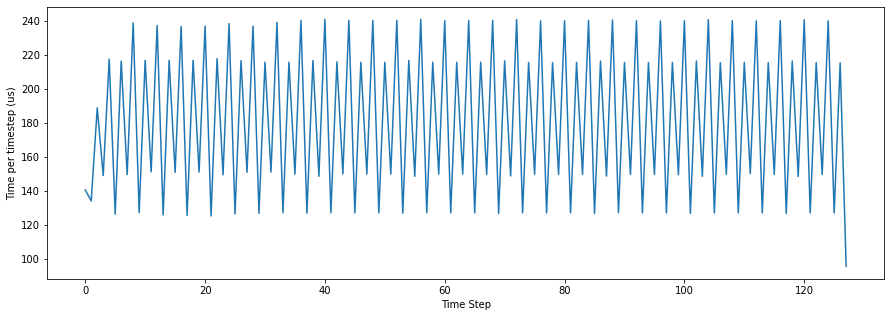

In [28]:
plt.figure(figsize=(15, 5))
plt.plot(runtime_logger.time_per_step)
plt.xlabel('Time Step')
plt.ylabel('Time per timestep (us)')

## Power Results

In [14]:
# power measurements
time_stamp = power_logger.time_stamp
vdd_p = power_logger.vdd_power  # neurocore power
vddm_p = power_logger.vddm_power  # memory power
vddio_p = power_logger.vddio_power  # IO power
total_power = vdd_p + vddm_p + vddio_p
num_measurements = len(vdd_p)
time = time_stamp * total_inference_time / time_stamp.max()

/home/sshresth/lava-nc/frameworks.ai.lava.lava-loihi/src/lava/utils/loihi2_profiler.py:119: UserWarning: Time measurement is not calibrated. The scale may not be exact.
  warnings.warn('Time measurement is not calibrated. '


### Compensate for unused chips on the board

In [15]:
num_chips = 1
if Loihi2.partition in ['kp', 'kp_stack', 'kp_build']:
    num_chips = 8

# per chip static power
static_total_power = power_logger.static_total_power / num_chips
static_vdd_p = power_logger.static_vdd_power / num_chips
static_vddm_p = power_logger.static_vddm_power / num_chips
static_vddio_p = power_logger.static_vddio_power / num_chips

# compensate for static power of multiple chip
total_power -= (num_chips - 1) * static_total_power
vdd_p -= (num_chips - 1) * static_vdd_p
vddm_p -= (num_chips - 1) * static_vddm_p
vddio_p -= (num_chips - 1) * static_vddio_p

In [16]:
total_power_mean = np.mean(total_power[:num_measurements // 2])
vdd_p_mean = np.mean(vdd_p[:num_measurements // 2])
vddm_p_mean = np.mean(vddm_p[:num_measurements // 2])
vddio_p_mean = np.mean(vddio_p[:num_measurements // 2])
print(f'Total Power   : {total_power_mean:.6f} W')
print(f'Dynamic Power : {total_power_mean - static_total_power:.6f} W')
print(f'Static Power  : {static_total_power:.6f} W')
print(f'VDD Power     : {vdd_p_mean:.6f} W')
print(f'VDD-M Power   : {vddm_p_mean:.6f} W')
print(f'VDD-IO Power  : {vddio_p_mean:.6f} W')

Total Power   : 0.826347 W
Dynamic Power : 0.474284 W
Static Power  : 0.352063 W
VDD Power     : 0.289861 W
VDD-M Power   : 0.529611 W
VDD-IO Power  : 0.006875 W


In [17]:
total_energy = total_power_mean / inference_rate
dynamic_energy = (total_power_mean - static_total_power) / inference_rate
print(f'Total Energy per inference   : {total_energy * 1e3:.6f} mJ')
print(f'Dynamic Energy per inference : {dynamic_energy * 1e3:.6f} mJ')

Total Energy per inference   : 2.414157 mJ
Dynamic Energy per inference : 1.385611 mJ


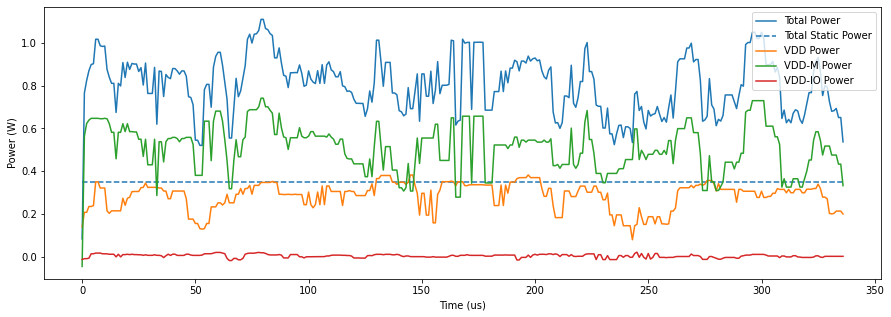

In [25]:
fig, ax = plt.subplots(figsize=(15, 5))
color = next(ax._get_lines.prop_cycler)['color']
ax.plot(total_power, color=color, label='Total Power')
ax.plot(np.zeros_like(total_power)
        + static_total_power,
        linestyle='--', color=color, label='Total Static Power')
color = next(ax._get_lines.prop_cycler)['color']
ax.plot(vdd_p, color=color, label='VDD Power')
color = next(ax._get_lines.prop_cycler)['color']
ax.plot(vddm_p, color=color, label='VDD-M Power')
color = next(ax._get_lines.prop_cycler)['color']
ax.plot(vddio_p, color=color, label='VDD-IO Power')
ax.set_ylabel('Power (W)')
ax.set_xlabel('Time (us)')
ax.legend()


## Activity Results

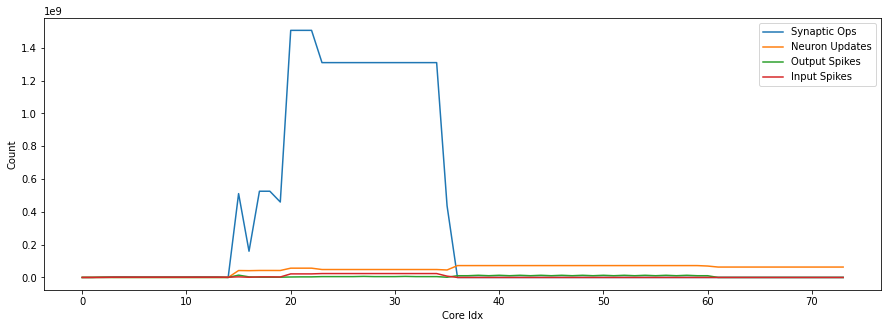

In [26]:
plt.figure(figsize=(15, 5))
plt.plot(activity_logger.core_idx, activity_logger.syn_ops, label='Synaptic Ops')
plt.plot(activity_logger.core_idx, activity_logger.dendrite_updates, label='Neuron Updates')
plt.plot(activity_logger.core_idx, activity_logger.axon_out, label='Output Spikes')
plt.plot(activity_logger.core_idx, activity_logger.spikes_in, label='Input Spikes')
plt.xlabel('Core Idx')
plt.ylabel('Count')
plt.legend()

## Memory Results

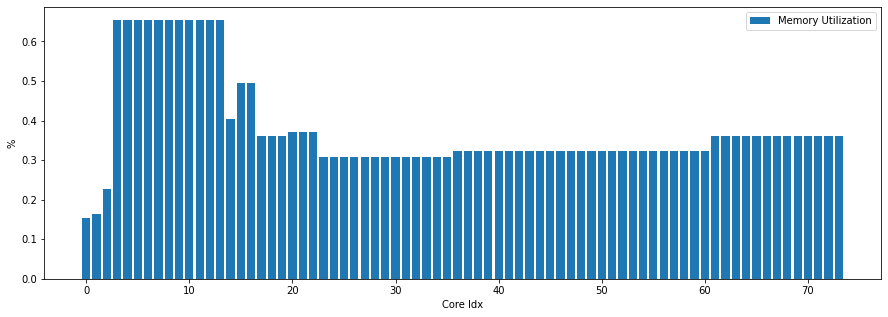

In [23]:
plt.figure(figsize=(15, 5))
plt.bar(memory_logger.core_idx, memory_logger.total_mpds, label='Memory Utilization')
plt.ylabel('%')
plt.xlabel('Core Idx')
plt.legend()